## Навигация:
* [Задача 1](#first-bullet)
* [Задача 2](#second-bullet)
* [Задача 3](#three-bullet)
* [Задача 4](#four-bullet)

Кратко о потраченном времени:

Задача 1 - потратил 4 часа, совершенно забыл многие вещи по SQL, пришлось вспоминать, сначала думал напишу запросы от руки, потом решил сгенерировать данные и проверить всё в работе

Задача 2 - 2 часа, мог потратить гораздо меньше, и не делать решение с сортировкой, но решил освежить в памяти работу алгоритма

Задача 3 - 2 часа, впринципе все было сразу понятно, но все таки решил покапаться в библиотеках python, вспомнить что делал в тетрадке из курса Coursera Специализация машинное обучение, и освежить в памяти лекцию Вадима Аббакумова по линейной регрессии

https://github.com/granesko/Coursera/blob/master/PA_linreg_stochastic_grad_descent.ipynb

https://www.youtube.com/watch?v=_PlC8Niun7U&t=3401s&ab_channel=ComputerScienceCenter

Задача 4 - сделал быстро

## Задача 1<a class="anchor" id="first-bullet"></a>


1.	Find the list of faculties with maximum sum grade points of students
2.	Get the list of students, having grades more than them head student
3.	Get the list of students from your city, which grade more than the average grade of the faculty
4.	Take the top 5 best students by the sum of scholarship in this term besides excluding the top 5 best students by the sum of scholarship in the previous term. 


![image.png] 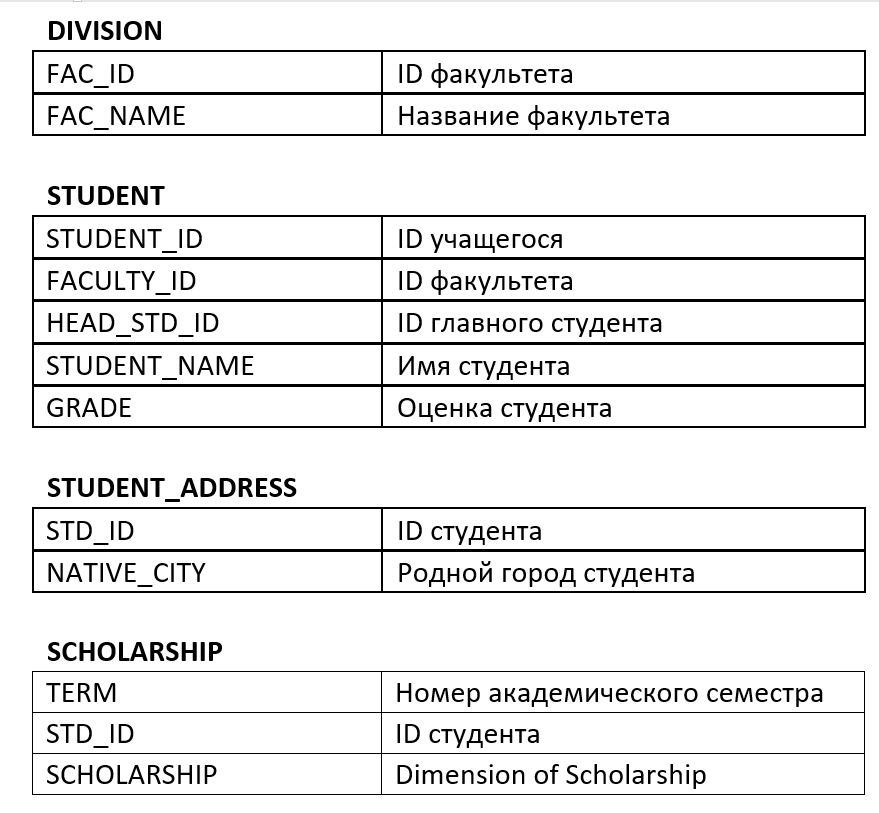


In [154]:
BEGIN TRANSACTION;
/*Создаем необходимые данные для тестовых запросов */
CREATE TABLE division(fac_id integer PRIMARY KEY, fac_name text);

INSERT INTO division VALUES(1,'history');
INSERT INTO division VALUES(2,'physical');
INSERT INTO division VALUES(3,'law');
COMMIT;

CREATE TABLE student(student_id integer PRIMARY KEY, faculty_id integer, head_std_id integer, student_name text, grade integer);
/*Подразумеваю, что главный студент один на все факультеты и это Вася Историк с id=2 */
/*Если студентов главных несколько, то можно делать как в третьем задании */
/*Я так подумал, потому что в задании написано  head student в единственном числе*/
INSERT INTO student VALUES(1, 1, 2, 'Петя Историк', 75); 
INSERT INTO student VALUES(2, 1, 2, 'Вася Историк', 91);
INSERT INTO student VALUES(3, 2, 2, 'Петя Физик',   88);
INSERT INTO student VALUES(4, 2, 2, 'Вася Физик',   50);
INSERT INTO student VALUES(5, 3, 2, 'Петя Юрист',   99);
INSERT INTO student VALUES(6, 3, 2, 'Вася Юрист',   23);

CREATE TABLE STUDENT_ADDRESS (STD_ID integer PRIMARY KEY, NATIVE_CITY text);

INSERT INTO STUDENT_ADDRESS VALUES(1, 'Ростов');
INSERT INTO STUDENT_ADDRESS VALUES(2, 'Ростов');
INSERT INTO STUDENT_ADDRESS VALUES(3, 'Ставрополь');
INSERT INTO STUDENT_ADDRESS VALUES(4, 'Ставрополь');
INSERT INTO STUDENT_ADDRESS VALUES(5, 'Москва');
INSERT INTO STUDENT_ADDRESS VALUES(6, 'Ставрополь');

CREATE TABLE SCHOLARSHIP (TERM integer, STD_ID integer, SCHOLARSHIP integer, PRIMARY KEY(TERM, STD_ID));

INSERT INTO SCHOLARSHIP VALUES (1, 1, 10000);
INSERT INTO SCHOLARSHIP VALUES (1, 2, 20000);
INSERT INTO SCHOLARSHIP VALUES (1, 3, 30000);
INSERT INTO SCHOLARSHIP VALUES (1, 4, 40000);
INSERT INTO SCHOLARSHIP VALUES (1, 5, 50000);
INSERT INTO SCHOLARSHIP VALUES (1, 6, 60000);
INSERT INTO SCHOLARSHIP VALUES (2, 1, 15000);
INSERT INTO SCHOLARSHIP VALUES (2, 2, 25000);
INSERT INTO SCHOLARSHIP VALUES (2, 3, 35000);
INSERT INTO SCHOLARSHIP VALUES (2, 4, 45000);
INSERT INTO SCHOLARSHIP VALUES (2, 5, 55000);
INSERT INTO SCHOLARSHIP VALUES (2, 6, 65000);


/* Делаем первый запрос */
/* 1) Find the list of faculties with maximum sum grade points of students */
SELECT DIVISION.FAC_NAME, SUM(STUDENT.GRADE)
FROM STUDENT
INNER JOIN DIVISION
  ON DIVISION.FAC_ID = STUDENT.FACULTY_ID
  GROUP BY DIVISION.FAC_ID
  ORDER BY SUM(STUDENT.GRADE) DESC;

/* Делаем второй запрос */
/* 2) Get the list of students, having grades more than them head student */
SELECT 
    STUDENT.STUDENT_NAME 
FROM STUDENT
WHERE STUDENT.GRADE > (
    SELECT student.GRADE 
    FROM STUDENT
    WHERE STUDENT.STUDENT_ID = HEAD_STD_ID);

/* Делаем третий запрос */
/* 3) Get the list of students from your city, which grade more than the average grade of the faculty */
select x.student_name from 
    (SELECT *  FROM STUDENT
    INNER JOIN STUDENT_ADDRESS ON STUDENT_ADDRESS.STD_ID = STUDENT.STUDENT_ID
    INNER JOIN division ON division.fac_id = STUDENT.faculty_id) as x
inner join
    (SELECT AVG(STUDENT.GRADE) as mean, division.fac_name  FROM STUDENT
    INNER JOIN STUDENT_ADDRESS ON STUDENT_ADDRESS.STD_ID = STUDENT.STUDENT_ID
    INNER JOIN division ON division.fac_id = STUDENT.faculty_id
    GROUP BY STUDENT.faculty_id) as y
ON x.fac_name = y.fac_name
where x.grade > y.mean and x.native_city = 'Ставрополь';

/* Делаем четвертый запрос */
/* 4) Take the top 5 best students by the sum of scholarship in this term besides excluding the top 5 best students by the sum of scholarship in the previous term. */
SELECT ST.student_name FROM SCHOLARSHIP AS S
INNER JOIN STUDENT AS ST
ON S.STD_ID = ST.student_id
WHERE S.TERM = 2 AND ST.student_name NOT IN
(
SELECT ST.student_name FROM SCHOLARSHIP AS S1
INNER JOIN STUDENT AS ST
ON S1.STD_ID = ST.student_id
WHERE S1.TERM = 1
ORDER BY S1.SCHOLARSHIP DESC
LIMIT 5
)
ORDER BY S.SCHOLARSHIP DESC
LIMIT 5;


/* Подсказка для удобства к третьему запросу */
/*
select * from 
(SELECT *  FROM STUDENT
INNER JOIN STUDENT_ADDRESS ON STUDENT_ADDRESS.STD_ID = STUDENT.STUDENT_ID
INNER JOIN division ON division.fac_id = STUDENT.faculty_id) as x
inner join
(SELECT AVG(STUDENT.GRADE), division.fac_name  FROM STUDENT
INNER JOIN STUDENT_ADDRESS ON STUDENT_ADDRESS.STD_ID = STUDENT.STUDENT_ID
INNER JOIN division ON division.fac_id = STUDENT.faculty_id
GROUP BY STUDENT.faculty_id) as y
ON x.fac_name = y.fac_name;*/

/* Подсказка к четвертому запросу */
/*  
SELECT S.TERM, S.STD_ID, S.SCHOLARSHIP, ST.student_name FROM SCHOLARSHIP AS S
INNER JOIN STUDENT AS ST
ON S.STD_ID = ST.student_id
WHERE S.TERM = 2
ORDER BY S.SCHOLARSHIP DESC;

SELECT S1.TERM, S1.STD_ID, S1.SCHOLARSHIP, ST.student_name FROM SCHOLARSHIP AS S1
INNER JOIN STUDENT AS ST
ON S1.STD_ID = ST.student_id
WHERE S1.TERM = 1
ORDER BY S1.SCHOLARSHIP DESC
LIMIT 5;*/


SyntaxError: invalid syntax (<ipython-input-154-4e4484f329ba>, line 1)

## Задача 2 <a class="anchor" id="second-bullet"></a>

Дана последовательность целых чисел от 1 до N. Из нее случайно удалили одно число, а оставшиеся числа перемешали. И получили последовательность a(1),a(2),…., a(N-1). Необходимо написать программу (на любом языке, можно использовать псевдокод), которая находит удалённое число.

### Генерируем необходимые данные

In [138]:
import time
import random

n = int(input('Введите N\n'))

a = [i for i in range(n)] # Первый список 1-N
b = random.randint(1, n) # Случайное число, которое удалим из второго списка
c = a.copy() # Второй список
random.shuffle(c) # Перемешиваем список
c.remove(b) # Удаляем случайный элемент

print('Список 1-N \n',a)
print('Перемещанный список без одного элемента\n',c)
print('Удаленный элемент \n', b)

Введите N
34
Список 1-N 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Перемещанный список без одного элемента
 [30, 22, 4, 10, 11, 33, 28, 16, 6, 25, 8, 23, 32, 19, 24, 0, 1, 18, 3, 12, 13, 2, 29, 21, 20, 7, 14, 15, 17, 9, 27, 5, 26]
Удаленный элемент 
 31


### Решаем задачу

Есть два решения:
1. Посчитать суммы двух списков, ответом будет разность этих сумм
2. Отсортировать второй список и сравнивать два списка поэлементно, место, в котором будет несовпадение, будет являться ответом

### Решение первым способом

In [141]:
start_time = time.time() 
# можете попробовать решения на более больших данных (10тыс. элементов) и сравнить какое решение быстрее

x = sum(a) - sum(c) # решение с помощью метода sum()

print('Ответ: ', x)
print('\nПотраченное время: \n', time.time()-start_time)

Ответ:  31

Потраченное время: 
 0.0005004405975341797


##### Решаем без встроенных методов

Посчитаем сумму первого ряда по формуле ниже, т.к. это арифметическая прогрессия

$$sum = \frac{(a_1+a_n)n}{2}$$

Посчитаем сумму второго списка помощью цикла

In [140]:
start_time = time.time()

sum_a = int((a[0]+a[-1])*(a[-1]+1)/2) # считаем сумму первого списка

sum_c = 0
for i in c: # считаем сумму второго списка
    sum_c+=i
x2 = sum_a - sum_c    
print('Ответ: ',x2)

print('\nПотраченное время: \n', time.time()-start_time)

Ответ:  31

Потраченное время: 
 0.0004999637603759766


### Решение вторым способом

In [142]:
c1 = c.copy()
print(c1)

[30, 22, 4, 10, 11, 33, 28, 16, 6, 25, 8, 23, 32, 19, 24, 0, 1, 18, 3, 12, 13, 2, 29, 21, 20, 7, 14, 15, 17, 9, 27, 5, 26]


In [143]:
# алгоритм пирамидальной сортировки, я ее считаю одной из самых быстрых поэтому решил использовать здесь

def heapify(arr, n, i):
    largest = i # Initialize largest as root
    l = 2 * i + 1   # left = 2*i + 1
    r = 2 * i + 2   # right = 2*i + 2

  # Проверяем существует ли левый дочерний элемент больший, чем корень

    if l < n and arr[i] < arr[l]:
        largest = l

    # Проверяем существует ли правый дочерний элемент больший, чем корень

    if r < n and arr[largest] < arr[r]:
        largest = r

    # Заменяем корень, если нужно
    if largest != i:
        arr[i],arr[largest] = arr[largest],arr[i] # свап

        # Применяем heapify к корню.
        heapify(arr, n, largest)

# Основная функция для сортировки массива заданного размера
def heapSort(arr):
    n = len(arr)

    # Построение max-heap.
    for i in range(n, -1, -1):
        heapify(arr, n, i)

    # Один за другим извлекаем элементы
    for i in range(n-1, 0, -1):
        arr[i], arr[0] = arr[0], arr[i] # свап 
        heapify(arr, i, 0)

In [145]:
start_time = time.time()

heapSort(c1)
for i in range(len(a)):
    if a[i]!=c1[i]:
        print('Ответ: ', a[i])
        break

print('\nПотраченное время: \n', time.time()-start_time)

Ответ:  31

Потраченное время: 
 0.0004999637603759766


## Задача 3 <a class="anchor" id="three-bullet"></a>

Даны две выборки наблюдений переменных X и Y: X1,…,Xn  и Y1,…,Yn .

Напишите формулы для следующих значений:

1. Среднее арифметическое  X
2. Среднеквадратичное отклонение Sx
3. Как определяется коэффициент корреляции между X и Y?
4. В регрессии   известны следующие данные 

n = 12

R2 = 0.65	

B = 4.2	

p-value (b)	= 0.0011

A = 0.52	

p-value (a) = 0.4581

Вычислите прогноз Y для значения X=10 по оцененной регрессии. Вас что-то смущает в данных?

5. напишите общую формулу авторегрессии второго порядка.


### 1. Считаем среднее арифметическое, это отношение суммы чисел к количеству чисел из ряда X

In [189]:
x = [2,3,5,3,4,7,4,3,4,6,4,4,3,3,4,5,5,4] # вводим данные для расчетов
sr_arif = sum(x)/len(x)
sr_arif

4.055555555555555

### 2. Считаем среднеквадратичное отклонение Sx

In [197]:
import numpy as np
from math import sqrt

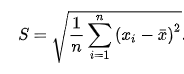

In [191]:
# используем метод определяющий среднеквадратичное отклонение из библиотеки numpy
print(round(np.std(x),3), '  с методом')
# посчитаем по формуле не используя метод
sigma = round(sqrt(sum([(i - sr_arif)**2 for i in x])/len(x)),3)
print(sigma, '  без метода')

1.177   с методом
1.177   без метода


### 3. Как определяется коэффициент корреляции между X и Y?

Сразу же уточним, что все что мы посчитали раннее, нам пригодится, из среднего арифметического мы получаем среднеквадратичное отклонение, а с помощью среднеквадратичного отклонения мы получаем Коэффициент корреляции, если считаем с помощью метода Пирсона

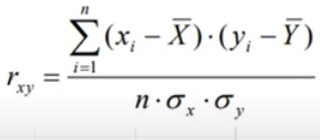

Коэффициент корреляции может определяться несколькими способами, первый - с помощью критерия Пирсона или хи-квадрат в python scipy.stats.chisquare или же второй способ - критерий Спирмена в python scipy.stats.spearmanr

Критерий Пирсона надо применять, когда у нас нормальное распределение

Критерий Спирмена - когда у нас X и Y не распределены нормально

Как понять, какое распределение?
Можно посмотреть на гистограмму и оценить ее взглядом, а можно применить критерий Шапиро-Уилко где нулевая гипотеза говорит, что распределение нормальное и оценить p-value

In [192]:
from scipy import stats
import matplotlib.pyplot as plt

(array([1., 5., 7., 3., 2.]),
 array([2., 3., 4., 5., 6., 7.]),
 <a list of 5 Patch objects>)

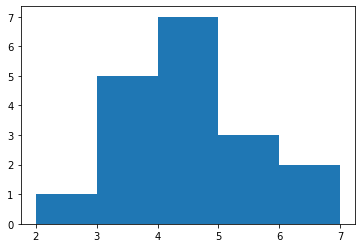

In [193]:
plt.hist(x, bins = 5)

In [194]:
res = stats.shapiro(x)
print('p-value: ', res[1],'\nКритерий ', res[0])

p-value:  0.09659624099731445 
Критерий  0.9128495454788208


Формула для расчета коэффициента корреляции Пирсона

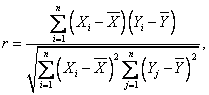

Зачем все это нужно?

Обычно после предобработки данных анализируют корреляцию признаков, чтобы коррелирующие признаки убрать, иначе они будут мешать обучению ML модели

на картинке метод визуализации seaborn.heatmap и для просчета использовался метод pandas.corr()
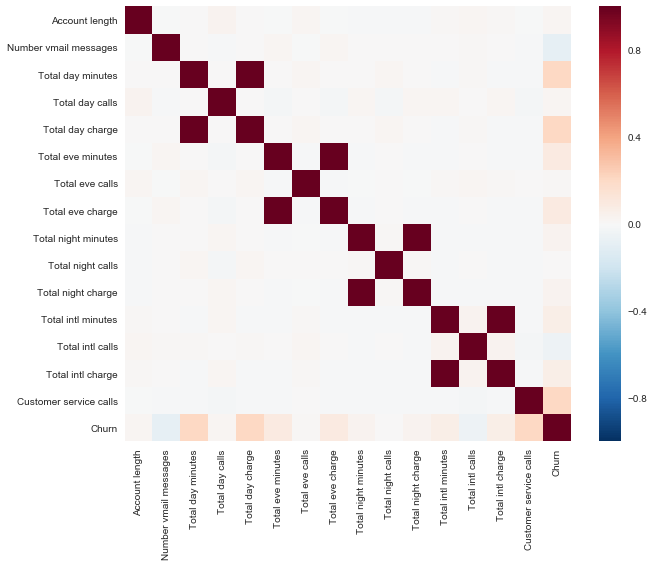

### 4. В регрессии известны следующие данные, вычислите Y

$$ Y = A + BX$$

In [196]:
A = 0.52
B = 4.2
X = 10
Y = A + B*X
print('Прогноз: ', Y)

Прогноз:  42.52


R^2 - Это коэфициент детерминации
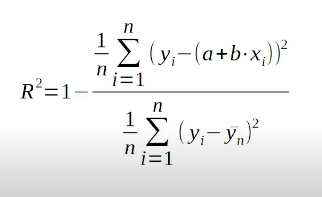

в числителе у нас находится среднее квадратичное отклонение (MSE, СКО), которое считается с помощью метода наименьших квадратов, а в знаменателе находится выборочная дисперсия, если углубляться в подробности, то можно сделать вывод, что из-за того чтобы понять хорошо или плохо мы оптимизировали Q-критерий качества, мы сравниваем наш числитель с базовым решением, где Y у нас всегда один и тот же, именно из за этого наш коэфициент сможет принимать значения от 0 до 1, где 1 - это отсутствие ошибки, а 0 - это наше базовое решение с максимальным отклонением, где Y является константой.

Вывод: чем больше R^2 тем лучше решение

На самом деле коэффициента детерминации обычно мало для каких-то выводов, потому что существуют наборы данных, которые могут ввести в заблуждение, отличные примеры таких ситуаций можно увидеть в "Квартете Анскомба", там можно увидеть как выбросы могут испортить общую картину, хотя R^2 достаточно хороший, а так же можно допустить ошибку спецификации (например, у нас там параболическая зависимость)

Поэтому всегда необходимо визуализировать данные при применении линейной регрессии.

Так же у нас есть p-value(a) и p-value(b), не указано какую именно гипотезу они проверяют, но в данной задаче будет логичным предположить, что наша нулевая гипотеза заключается в том, что коэффициент признака равен 0, другими словами - несет ли этот признак в себе смысл для нашего прогноза или же он никак не влияет.

В python для этого можно использовать scipy.stats.t.sdf - Кумулятивная функция распределения.

### 5. Напишите общую формулу авторегрессии второго порядка.

$$ Y = A + BX + CX^2$$

Иногда бывает так, что нам нужно достраивать еще дополнительные полиномы, потому что Y может быть нелинейно зависим от X

Например, есть задача, когда мы прогнозируем цену бриллианта от количества карат, и в отличии от угля (где стоймость за тонну это линейная регрессия) у алмаза цена вырастает в квадрате от изменения количества карат, и используя формулу регрессии второго порядка, мы поймем, что коэффициент C имеет большее влияние, и получим более качественный прогноз

## Задача 4 <a class="anchor" id="four-bullet"></a>